# Exploração ML do readcounts 
É um dataset com a abundancia taxonomica

In [15]:
import numpy as np
import pandas as pd

readcounts_train = pd.read_csv("train/readcounts_training.csv")
readcounts_test = pd.read_csv("test/readcounts_test.csv")
pheno_train = pd.read_csv("train/pheno_training.csv")
pheno_test = pd.read_csv("test/pheno_test.csv")


#### Pré-processamento de dados

In [16]:
# get indexes of the rows without nan values
inds_train = pheno_train.dropna().index
inds_test = pheno_test.dropna().index

# data structure organization - train
pheno_train_y = pheno_train.PrevalentHFAIL[inds_train]
readcounts_train_X = readcounts_train.iloc[:, 1:].T # tranpose dataset for compablility
readcounts_train_X.columns = list(readcounts_train["Unnamed: 0"]) # renaming columns for acessibility
readcounts_train_X = readcounts_train_X.iloc[inds_train] # using only rows without nan

# data structure organization - test
pheno_test_y = pheno_test.PrevalentHFAIL[inds_test]
readcounts_test_X = readcounts_test.iloc[:, 1:].T # tranpose dataset for compablility
readcounts_test_X.columns = list(readcounts_test["Unnamed: 0"]) # renaming columns for acessibility
readcounts_test_X = readcounts_test_X.iloc[inds_test] # using only rows without nan

## Feature selection
#### PCA

In [4]:
from sklearn.decomposition import PCA
pca_train = PCA(n_components=0.8)
pca_train.fit(readcounts_train_X)
train_X_reduced = pca_train.transform(readcounts_train_X)
train_X_reduced.shape[1]

11

Var. explained: [0.34929262 0.12501638 0.09953579 0.06496586 0.03921372 0.03325387
 0.02573278 0.02350203 0.01771732 0.01553283 0.01511039]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (10,).

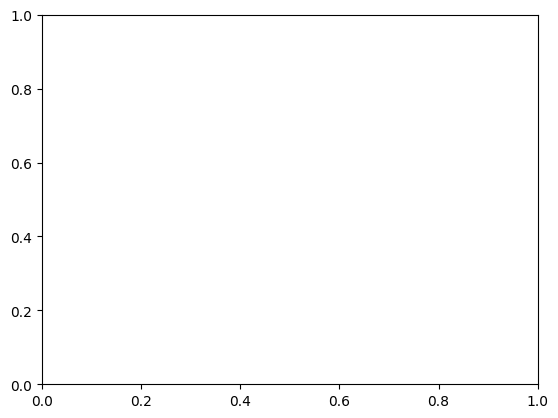

In [5]:
import matplotlib.pyplot as plt
print('Var. explained: %s'% str(pca_train.explained_variance_ratio_))
n_pc = 8
plt.bar(range(n_pc), pca_train.explained_variance_ratio_[0:10]*100)
plt.xticks(range(n_pc), ['PC'+str(i) for i in range(1,n_pc+1)])
plt.title("Explained variance")
plt.ylabel("Percentage")
plt.show()

In [ ]:
# Falta o grafico
# Criar um lista com a classificação de HF
"""
Nunca tiveram: PrevalentHFAIL == 0 and Event == 0
Só tiveram previamente: PrevalentHFAIL == 1 and Event == 0
Só tiveram durante: PrevalentHFAIL == 0 and Event == 1
Tiveram antes e durante: PrevalentHFAIL == 1 and Event == 1
"""
pheno_train.dropna()
tipo_HF = []
for i in range(pheno_train.shape[0]):
    if pheno_train.loc[i]["PrevalentHFAIL"] == 0 and pheno_train.loc[i]["Event"] == 0:
        tipo_HF.append("Nunca")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 1 and pheno_train.loc[i]["Event"] == 0:
        tipo_HF.append("SoAntes")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 0 and pheno_train.loc[i]["Event"] == 1:
        tipo_HF.append("SoDurante")
    elif pheno_train.loc[i]["PrevalentHFAIL"] == 1 and pheno_train.loc[i]["Event"] == 1:
        tipo_HF.append("AntesDurante")

print(len(tipo_HF))
HF_Nunca = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "Nunca"]
HF_SoAntes = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "SoAntes"]
HF_SoDurante = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "SoDurante"]
HF_AntesDurante = [i for i in range(len(tipo_HF)) if tipo_HF[i] == "AntesDurante"]


# Grafico
plt.plot(train_X_reduced[HF_Nunca,0],train_X_reduced[HF_Nunca,1],'o',label="Nunca")
plt.plot(train_X_reduced[HF_SoAntes,0],train_X_reduced[HF_SoAntes,1],'o',label="SoAntes")
plt.plot(train_X_reduced[HF_SoDurante,0],train_X_reduced[HF_SoDurante,1],'o',label="SoDurante")
plt.plot(train_X_reduced[HF_AntesDurante,0],train_X_reduced[HF_AntesDurante,1],'o',label="AntesDurante")
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show()


3564


IndexError: index 3540 is out of bounds for axis 0 with size 3540

In [ ]:
from sklearn.cluster import KMeans

k=6
kmeans_har = KMeans(n_clusters=k, max_iter=1000)
kmeans_har.fit(readcounts_train_X)
labels = kmeans_har.labels_

pd.crosstab(labels, tipo_HF, rownames=['clusters'] )

ValueError: All arrays must be of the same length

## Medelos de ML
#### Logistic Regression

In [6]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(readcounts_train_X, pheno_train_y)
logistic_prev = logistic.predict(readcounts_test_X)

print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

PECC (accuracy): 0.9586167800453514


c:\Users\Tiago\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Linear Regression

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

regr_model = linear_model.LinearRegression()
regr_model = regr_model.fit(readcounts_train_X, pheno_train_y)
regr_model_pred = regr_model.predict(readcounts_test_X)

print(regr_model_pred)

print("Perc. acertos: ", (regr_model_pred == pheno_test_y).sum()/len(regr_model_pred))

[ 0.87261827 -0.35912821  1.32509594 ...  1.25286809  0.0154085
  0.28186538]
Perc. acertos:  0.0


#### SVM's

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVM = svm.SVC(gamma=0.001, C=100.)
SVM = SVM.fit(readcounts_train_X, pheno_train_y)
svm_pred = SVM.predict(readcounts_test_X)
print("PECC (accuracy):", accuracy_score(pheno_test_y, svm_pred))

PECC (accuracy): 0.9784580498866213


#### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(readcounts_train_X, pheno_train_y)
knn_pred = knn.predict(readcounts_test_X)
print("Perc. acertos: ", (knn_pred == pheno_test_y).sum()/len(knn_pred))

Perc. acertos:  0.9784580498866213


#### Decision Tree

In [ ]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(readcounts_train_X, pheno_train_y)
preds_tree = tree_model.predict(readcounts_test_X)

print("Perc. acertos: ", (preds_tree == pheno_test_y).sum()/len(preds_tree))

Perc. acertos:  0.9370748299319728


### Ensembles
#### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
DTree = tree.DecisionTreeClassifier(max_depth=4)
knn_class = KNeighborsClassifier(n_neighbors=7)
svc = svm.SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', DTree), ('knn', knn_class), ('svc', svc)], voting='hard')

eclf = eclf.fit(readcounts_train_X, pheno_train_y)
print(eclf.score(readcounts_test_X, pheno_test_y))

0.9784580498866213


### Random Forest

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [2, 3, None], "max_features": [2,4,6], "min_samples_split": [2,4,6],
              "min_samples_leaf": [2,4,6], "bootstrap": [True, False], "criterion": ["gini", "entropy"]}

rand_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=20, cv = 5)
rand_search =rand_search.fit(readcounts_train_X, pheno_train_y)
print (rand_search.best_estimator_)
report(rand_search.cv_results_)
print(rand_search.score(readcounts_test_X, pheno_test_y))

RandomForestClassifier(max_features=2, min_samples_leaf=4)
Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 4, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 6, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 2, 'max_depth': 2, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 2, 'max_dept

# Feature Selecting

In [ ]:
s = readcounts_train_X.sum()
top_sum_features = readcounts_train_X[s.sort_values(ascending=False).index[:100]].columns
df_100 = readcounts_train_X[top_sum_features]
df_100

,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_uniformis,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__Faecalibacterium_prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__Blautia_obeum,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__Prevotella_copri,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia_inulinivorans,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_ovatus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia_intestinalis,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__Roseburia_faecis,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes_putredinis,...,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Faecalitalea;s__Faecalitalea_cylindroides,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Butyricicoccus;s__Butyricicoccus_pullicaecorum,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus;s__Acidaminococcus_intestini,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__Coprobacter;s__Coprobacter_fastidiosus,k__Bacteria;p__Firmicutes;c__Erysipelotrichia;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Erysipelatoclostridium;s__[Clostridium]_innocuum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium]_asparagiforme,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium]_citroniae,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Dialister;s__Dialister_succinatiphilus,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Faecalicatena;s__Faecalicatena_contorta,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Eggerthellales;f__Eggerthellaceae;g__Eggerthella;s__Eggerthella_lenta
Simulated_328,16132,20961,40584,41208,276290,37843,9048,40878,20629,28523,...,264,961,7,768,1188,1279,528,34153,445,342
Simulated_1644,339945,21652,6214,6830,214,5536,469820,3137,12531,418,...,15,44,0,74,55,62,274,0,84,20
Simulated_1710,32817,7992,36122,21281,359562,14618,17732,13654,3651,86,...,548,412,39,306,682,207,155,18,475,278
Simulated_1732,279370,276025,28165,38238,29603,30166,25784,3176,17928,33640,...,297,405,50218,1285,147,368,103,4,431,127
Simulated_1727,32273,18958,25612,9100,125,18613,18254,31899,1438,98275,...,800,274,1,15,1395,316,140,72,266,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Simulated_1783,223095,125270,52314,27939,232,62365,18964,252256,4650,48562,...,783,2645,30,59,1339,872,883,4,1163,46
Simulated_3425,29356,72741,13493,16954,87,7427,32475,10017,3490,12433,...,719,466,2,671,335,244,246,8,635,47
Simulated_1789,73522,268,11726,8109,306,9063,3907,12071,3206,1559,...,255,628,0,97,232,428,323,13,281,13
Simulated_1592,62928,4699,21409,8272,1043,6038,3818,4896,9862,18587,...,310,1125,5,90,270,331,72,2,293,21


In [ ]:
# Select percentile
import sklearn
from sklearn.feature_selection import SelectPercentile, chi2
X = readcounts_train_X
y = pheno_train_y
selection = SelectPercentile(chi2, percentile=10)
X_new = selection.fit_transform(X,y)
feature_names = selection.get_feature_names_out()

574

In [17]:
# Select Fpr
import sklearn
from sklearn.feature_selection import SelectFpr, chi2
print(readcounts_train_X.shape)
X = readcounts_train_X
y = pheno_train_y
selection_fpr = SelectFpr(chi2, alpha= 0.00001)
X_aux = selection_fpr.fit_transform(X,y)
feature_names_fpr = selection_fpr.get_feature_names_out()
print(len(feature_names_fpr))

(3540, 5748)
854


## Dataset with the selected features

In [18]:
readcounts_train_selected = readcounts_train_X[feature_names_fpr]
readcounts_test_selected = readcounts_test_X[feature_names_fpr]
patients, features_new = readcounts_train_selected.shape
patients, features_old = readcounts_train_X.shape
perc_reduced = (features_old - features_new)/features_new * 100
print(f"Dataset reduced by {int(perc_reduced)} %.")

Dataset reduced by 573 %.


In [10]:
# Logistic regression

logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(readcounts_train_selected, pheno_train_y)
logistic_prev = logistic.predict(readcounts_test_selected)

print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

PECC (accuracy): 0.9614512471655329


c:\Users\Tiago\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Random Forest

In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [2, 3, None], "max_features": [2,4,6], "min_samples_split": [2,4,6],
              "min_samples_leaf": [2,4,6], "bootstrap": [True, False], "criterion": ["gini", "entropy"]}

rand_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=20, cv = 5)
rand_search =rand_search.fit(readcounts_train_selected, pheno_train_y)
print (rand_search.best_estimator_)
report(rand_search.cv_results_)
print(rand_search.score(readcounts_test_selected, pheno_test_y))

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=2,
                       max_features=2, min_samples_leaf=6, min_samples_split=6)
Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 2, 'max_depth': 2, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 6, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.974 (std: 0.001)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 6, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 1
Mean validation score:

## Smote

In [19]:
# SMOTE -> used for unbalanced data sets 
# Synthetic Minority Over-sampling Technique
from collections import Counter
print('Original dataset shape %s' % Counter(pheno_train_y))
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
readcounts_train_selected, pheno_train_y = sm.fit_resample(readcounts_train_selected, pheno_train_y)
print('Resampled dataset shape %s' % Counter(pheno_train_y))


Original dataset shape Counter({0.0: 3448, 1.0: 92})
Resampled dataset shape Counter({0.0: 3448, 1.0: 3448})


In [20]:
logistic = linear_model.LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")
logistic = logistic.fit(readcounts_train_selected, pheno_train_y)
logistic_prev = logistic.predict(readcounts_test_selected)

print("PECC (accuracy):", accuracy_score(pheno_test_y, logistic_prev))

PECC (accuracy): 0.7738095238095238


c:\Users\Tiago\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
readcounts_train_selected

,k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Halobacteriales;f__Haloarculaceae;g__Halapricum;s__Halapricum_salinum,k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Natronorubrum;s__Natronorubrum_sulfidifaciens,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium;s__Methanobacterium_sp._MB1,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_arboriphilus,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_smithii,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera;s__Methanosphaera_stadtmanae,k__Archaea;p__Euryarchaeota;c__Thermococci;o__Thermococcales;f__Thermococcaceae;g__Thermococcus;s__Thermococcus_thioreducens,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Candidatus_Methanomethylophilus;s__Candidatus_Methanomethylophilus_alvus,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Candidatus_Methanomethylophilus;s__Candidatus_Methanomethylophilus_sp._1R26,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus;s__Candidatus_Methanomassiliicoccus_intestinalis,...,k__BacteriaPlasmid;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Erwiniaceae;g__Pantoea;s__Pantoea_sp._PSNIH2,k__BacteriaPlasmid;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Morganellaceae;g__Xenorhabdus;s__Xenorhabdus_nematophila,k__BacteriaPlasmid;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__Treponema_succinifaciens,"k__Viruses;p__dsDNA_viruses,_no_RNA_stage;c__Caudovirales;o__;f__;g__;s__",k__Viruses;p__ssDNA_viruses;c__Inoviridae;o__;f__;g__;s__,k__Viruses;p__ssDNA_viruses;c__Microviridae;o__;f__;g__;s__,"k__Viruses;p__ssRNA_viruses;c__ssRNA_positive-strand_viruses,_no_DNA_stage;o__Nidovirales;f__Coronaviridae;g__;s__","k__Viruses;p__ssRNA_viruses;c__ssRNA_positive-strand_viruses,_no_DNA_stage;o__Picornavirales;f__Picornaviridae;g__Enterovirus;s__Enterovirus_H",k__Viruses;p__unclassified_bacterial_viruses;c__Enterobacteria_phage_YYZ-2008;o__;f__;g__;s__,k__Viruses;p__unclassified_bacterial_viruses;c__Streptococcus_phage_phiARI0468-2;o__;f__;g__;s__
Simulated_328,350,0,0,0,0,0,0,1,2,0,...,0,0,0,123,0,7,0,0,3,0
Simulated_1644,115,0,0,0,0,0,0,2,0,1,...,0,0,0,47,0,0,0,0,0,0
Simulated_1710,38,0,0,0,12,0,0,0,0,0,...,0,0,0,82,0,0,0,0,0,0
Simulated_1732,21,0,0,0,1503,0,0,1,2,0,...,0,0,0,50,0,0,0,0,0,0
Simulated_1727,137,0,0,2,2,0,0,0,1,0,...,0,0,0,292,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Simulated_1783,672,0,0,0,3317,0,0,0,3,0,...,0,0,0,6538,0,9,0,0,6,0
Simulated_3425,25,0,0,0,8041,0,0,5,2,0,...,0,0,0,36,0,0,0,0,0,0
Simulated_1789,74,0,0,0,0,0,0,0,0,3209,...,0,0,0,488,0,3,0,0,0,0
Simulated_1592,129,0,5,0,2,6,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0
